# Chapter 11: Bayesian statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, scoreatpercentile
import pingouin as pg
import matplotlib

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')
%load_ext rpy2.ipython

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['Weight']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(123456)

## Figure 11.2

Text(0.5, 0, 'number of responders')

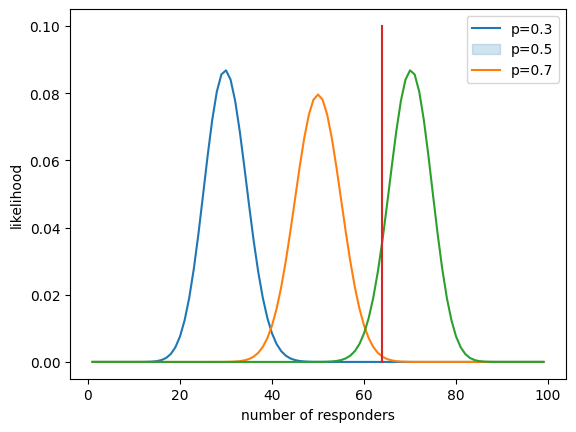

In [2]:
nResponders = 64
nTested = 100

drugDf = pd.DataFrame({'outcome': ["improved", "not improved"],
                       'number': [nResponders, nTested - nResponders]})

likeDf = pd.DataFrame({'resp': np.arange(1, 100)})
likeDf['presp'] = likeDf.resp / 100
for p in [.3, .5, .7]:
    label = f'likelihood{(p * 10):.0f}'
    likeDf[label] = binom.pmf(likeDf.resp, 100, p)
    sns.lineplot(data=likeDf, x='resp', y=label)
plt.legend(['p=0.3', 'p=0.5', 'p=0.7'])
plt.plot([drugDf.number[0], drugDf.number[0]], [0, .1])
plt.ylabel('likelihood')
plt.xlabel('number of responders')


## Figure 11.3

Text(0, 0.5, 'posterior probability of the observed data')

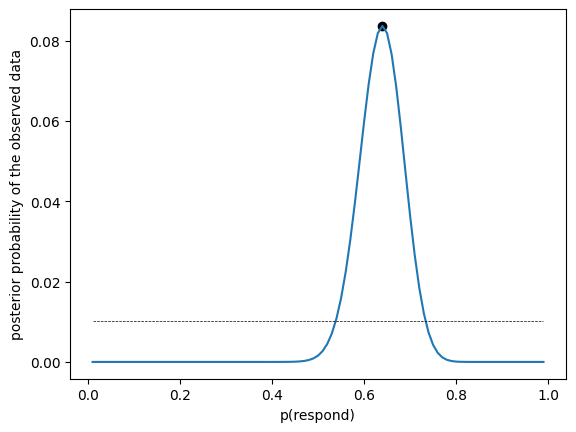

In [3]:
likeDf['uniform_prior'] = 1 / likeDf.shape[0]

marginal_likelihood = np.sum(binom.pmf(nResponders, nTested, likeDf.presp) * likeDf.uniform_prior)

bayesDf = pd.DataFrame({'steps': np.arange(.01, 1.0, .01)})
bayesDf['likelihoods'] = binom.pmf(nResponders, nTested, bayesDf.steps)
bayesDf['priors'] = 1 / bayesDf.shape[0]
bayesDf['posteriors'] = (bayesDf.likelihoods * bayesDf.priors) / marginal_likelihood
maxidx = bayesDf.posteriors.argmax()
MAP = bayesDf.steps[maxidx]

sns.lineplot(data=bayesDf, x='steps', y='posteriors')
plt.scatter([MAP], bayesDf.posteriors.max(), color='black')
sns.lineplot(data=bayesDf, x='steps', y='priors', color='black', linewidth=.5, linestyle='dashed')
plt.xlabel('p(respond)')
plt.ylabel('posterior probability of the observed data')


## Figure 11.4

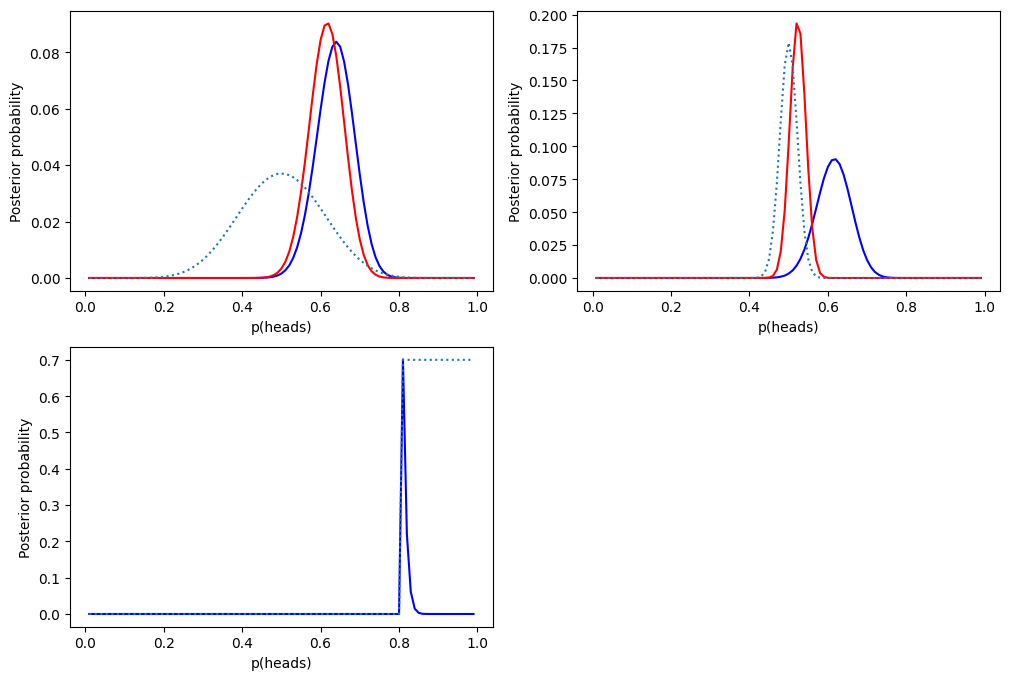

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))


bayesDf = pd.DataFrame({'steps': np.arange(.01, 1.0, .01)})
bayesDf['likelihoods'] = binom.pmf(nResponders, nTested, bayesDf.steps)
bayesDf['priors_flat'] = 1 / bayesDf.shape[0]
bayesDf['priors_absolute'] = 0
bayesDf.loc[bayesDf.steps > 0.8, 'priors_absolute'] = 1
bayesDf.priors_absolute = bayesDf.priors_absolute / bayesDf.priors_absolute.sum()
bayesDf['priors_empirical_weak'] = binom.pmf(10, 20, bayesDf.steps) / np.sum(binom.pmf(10, 20, bayesDf.steps))
bayesDf['priors_empirical_strong'] = binom.pmf(250, 500, bayesDf.steps) / np.sum(binom.pmf(250, 500, bayesDf.steps))

marginal_likelihood_flat = np.sum(binom.pmf(nResponders, nTested, bayesDf.steps) * bayesDf.priors_flat)
marginal_likelihood_weak = np.sum(binom.pmf(nResponders, nTested, bayesDf.steps) * bayesDf.priors_empirical_weak)
marginal_likelihood_strong = np.sum(binom.pmf(nResponders, nTested, bayesDf.steps) * bayesDf.priors_empirical_strong)
marginal_likelihood_absolute = np.sum(binom.pmf(nResponders, nTested, bayesDf.steps) * bayesDf.priors_absolute)


bayesDf['posteriors_flat'] = (bayesDf.likelihoods * bayesDf.priors_flat) / marginal_likelihood_flat
bayesDf['posteriors_weak'] = (bayesDf.likelihoods * bayesDf.priors_empirical_weak) / marginal_likelihood_weak
bayesDf['posteriors_strong'] = (bayesDf.likelihoods * bayesDf.priors_empirical_strong) / marginal_likelihood_strong
bayesDf['posteriors_absolute'] = (bayesDf.likelihoods * bayesDf.priors_absolute) / marginal_likelihood_absolute

sns.lineplot(data=bayesDf, x='steps', y='posteriors_flat', ax=ax[0][0], color='blue')
sns.lineplot(data=bayesDf, x='steps', y='posteriors_weak', ax=ax[0][0], color='red')
sns.lineplot(data=bayesDf, x='steps', y='priors_empirical_weak', ax=ax[0][0], linestyle='dotted')

sns.lineplot(data=bayesDf, x='steps', y='posteriors_weak', ax=ax[0][1], color='blue')
sns.lineplot(data=bayesDf, x='steps', y='posteriors_strong', ax=ax[0][1], color='red')
sns.lineplot(data=bayesDf, x='steps', y='priors_empirical_strong', ax=ax[0][1], linestyle='dotted')

sns.lineplot(data=bayesDf, x='steps', y='posteriors_absolute', ax=ax[1][0], color='blue')
bayesDf.loc[bayesDf.steps > 0.8, 'priors_absolute'] = 0.7  # rescale for figure
sns.lineplot(data=bayesDf, x='steps', y='priors_absolute', ax=ax[1][0], linestyle='dotted')


for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel("p(heads)")
        ax[i][j].set_ylabel("Posterior probability")

ax[1][1].set_visible(False)

## Figure 11.5

Text(0, 0.5, 'Change in hemoglobin A1C')

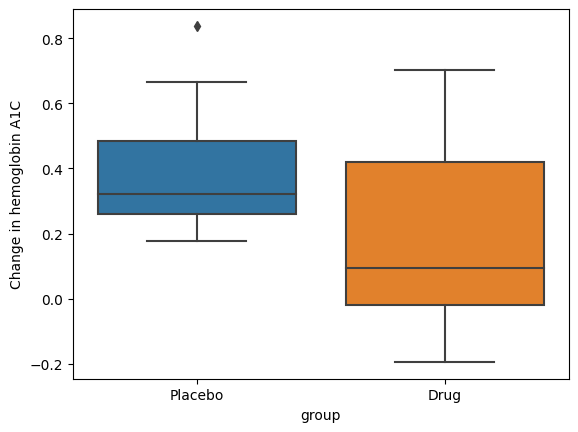

In [5]:
nsubs = 40
effect_size = 0.2
rng = np.random.default_rng(12345)

drugDf = pd.DataFrame({'group': ['Drug' if rng.uniform() > .5 else 'Placebo' for i in range(nsubs)]})
drugDf['hbchange'] =  rng.uniform(size=nsubs) - (drugDf.group == 'Drug') * effect_size

sns.boxplot(data=drugDf, x='group', y='hbchange')
plt.ylabel('Change in hemoglobin A1C')

## T-test for drug example

In [6]:

tt = pg.ttest(x=drugDf.query('group == "Placebo"').hbchange, 
              y=drugDf.query('group == "Drug"').hbchange,
              correction=True, alternative='greater')
tt

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.60501,31.58191,greater,0.006945,"[0.07, inf]",0.823776,8.104,0.819463


## Bayes factor for drug example

BF10 is generated by pg.ttest in cell above, but its method for one vs. two-tailed tests differs from that used in the BayesFactor package in R.

In [7]:
%%R -i drugDf

library(BayesFactor)
bf_drug <- ttestBF(
  formula = hbchange ~ group, data = drugDf,
  nullInterval = c(0, Inf)
)
bf_drug


R[write to console]: Error in (function (filename = "Rplot%03d.png", width = 480, height = 480,  : 
  Graphics API version mismatch

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages



RRuntimeError: Error in (function (filename = "Rplot%03d.png", width = 480, height = 480,  : 
  Graphics API version mismatch


## Bayes factor for one-sided tests

In [8]:
%%R 

bf_drug[1]/bf_drug[2]

Bayes factor analysis
--------------
[1] Alt., r=0.707 0<d<Inf : 0.01259155 ±0%

Against denominator:
  Alternative, r = 0.707106781186548, mu =/= 0 !(0<d<Inf) 
---
Bayes factor type: BFindepSample, JZS



## Table 11.1

In [9]:
# Compute credible intervals for example

nsamples = 100000

# create random uniform variates for x and y
x = rng.uniform(size=nsamples)
y = rng.uniform(size=nsamples)

# create f(x)
fx = binom.pmf(nResponders,nTested, x)

# accept samples where y < f(x)
accepted_samples = x[y < fx]

credible_interval = scoreatpercentile(accepted_samples, (2.5, 97.5))

credible_interval

array([0.54525307, 0.72923171])

## Figure 11.6

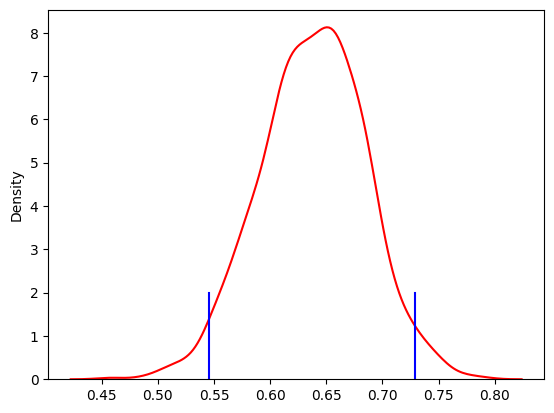

In [10]:
sns.kdeplot(accepted_samples, color='red')
for c in credible_interval:
    plt.plot([c, c], [0, 2], color='blue')